주가 예측 모형 구축

# 1. Setting Enviroment

## 1.1. Import library

In [1]:
# library import
import os
import sys
import time
import numpy as np
import scipy as sp
import pandas as pd
import re
from datetime import datetime, timedelta
from IPython.display import clear_output
import matplotlib.pyplot as plt

# crawling
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import json
import urllib3
import http.client

# Oracle DB 연동
import cx_Oracle

# autocomplete 작동 안될때
%config Completer.use_jedi = False

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

## 1.2. Connect Oracle

In [3]:
# 한글 지원
os.putenv('NLS_LANG', '.UTF8')

username = 'system'
password = 'kv5900'
host = 'localhost/orcl'

# DB connect
conn = cx_Oracle.connect(username, password, host)

In [4]:
# test sql code
pd.read_sql('select * from DUAL', conn)

,DUMMY
0,X


## 1.3. Setting working directory

In [5]:
os.chdir('E:\\github\\python\\stock')

In [6]:
os.getcwd()

'E:\\github\\python\\stock'

## 1.4. Setting Variables

#### 가장 최근 영업일 crawling

In [7]:
url = 'https://finance.naver.com/sise/sise_index.nhn?code=KOSPI'

html = urlopen(url)
source = BeautifulSoup(html.read(), "lxml")
text = source.find_all('span', id='time')[0].text

basc_dt = re.sub('\\.', '', re.findall(('[0-9]+.[0-9]+.[0-9]+'), text)[0])
print(basc_dt)

20210923


In [8]:
basc_dt='20210521'

In [9]:
stt_dt = '20000101'

# 2. Import Data

#### ticker 정보 호출

In [10]:
kr_tkr = pd.read_sql('select * from STC_DMS_TKR', conn)

In [11]:
data_sector = pd.read_sql('select * from STC_DMS_TKR_SCT', conn)

#### 재무분석 결과 rank 테이블 호출

In [12]:
q = "select * from STC_DMS_TKR_RNK where BASC_DT = '" + basc_dt + "'"
rank_db = pd.read_sql(q, conn)

#### 국내주식 정보 호출 (재무분석 결과에 따라 상위 ticker만 호출)

In [13]:
kr_tkr_slt = rank_db.sort_values('RANK').iloc[:30,1].tolist()

In [14]:
kr_tkr_slt = "'"+"','".join(kr_tkr_slt)+"'"

In [15]:
q = """

select *
  from STC_DMS_TKR_PRC
 where 1=1
   and BASC_DT between '"""+ stt_dt +"""' and '"""+ basc_dt +"""'
   and TKR_CD in ("""+kr_tkr_slt+""")

"""

price_slt = pd.read_sql(q, conn)
price_slt = price_slt.sort_values(['TKR_CD','BASC_DT']).reset_index(drop=True)

#### 주요 지표 호출

In [16]:
idx_list = {'STC_IDX_SP'      : 'SP',          # S&P
            'STC_IDX_DOW'     : 'DOW',         # 다우 
            'STC_IDX_NQ'      : 'NQ',          # 나스닥 
            'STC_IDX_RS2000'  : 'RS2000',      #러셀2000
            'STC_IDX_NI225'   : 'NI225',       # 일본
            'STC_IDX_SSE'     : 'SSE',         # 중국
            'STC_IDX_HSI'     : 'HSI',         # 홍콩
            'STC_IDX_FTSE'    : 'FTSE',        # 영국 
            'STC_IDX_FCHI'    : 'FCHI',        # 프랑스 
            'STC_IDX_GDAXI'   : 'GDAXI',       # 독일
            'STC_IDX_CLOIL'   : 'CLOIL',       # 크루드오일
            'STC_IDX_GOLD'    : 'GOLD',        # 금
            'STC_IDX_SILVER'  : 'SILVER',      # 은
            'STC_IDX_USD_KRW' : 'USD_KRW',     # 달러-원화
            'STC_IDX_USD_JPY' : 'USD_JPY',     # 달러-엔화
            'STC_IDX_USD_EUR' : 'USD_EUR',     # 달러-유로
            'STC_IDX_USD_GBP' : 'USD_GBP',     # 달러-영국파운드
            'STC_IDX_BTC_USD' : 'BTC_USD',     # 비트코인 달러
            'STC_IDX_BTC_KRW' : 'BTC_KRW',     # 비트코인 한화
            'STC_IDX_KOSPI'   : 'KOSPI',       # 코스피
            'STC_IDX_KOSDAQ'  : 'KOSDAQ',      # 코스닥
            'STC_IDX_KPI200'  : 'KPI200'       # 코스피200
           }

In [17]:
# 모든 데이터 호출
for db_df, out_df in idx_list.items():
    q = "select * from "+ db_df + " where BASC_DT between " + stt_dt + " and " + basc_dt
    exec("{} = pd.read_sql(q, conn)".format(out_df))
    
    # 컬럼명 변경 (종가,저가,고가,시가 앞에 지표명 추가)
    exec("{}.rename(columns = dict(zip({}.columns[2:], '{}'+'_'+{}.columns[2:])), inplace=True)".format(out_df, out_df, out_df, out_df))

In [18]:
# 지표테이블 조인
for i, val in enumerate(idx_list.items()):
    
    db_df = val[0] # input table name (in sql)
    out_df = val[1] # call table name (in python)
    
    # loop를 위해.. df로 테이블명 통일
    exec("df = {}".format(out_df))
    
    df = df.drop('IDX_CD', inplace=False, axis=1) # IDX_CD 컬럼 제거
    if (i == 0):
        idx_df = df
    else:
        idx_df = idx_df.merge(df, how='outer', on='BASC_DT')
        
# order by BASC_DT        
idx_df = idx_df.sort_values('BASC_DT').reset_index(drop=True)

# 모든 컬럼값이 0 or na인 경우 제외
idx_df = idx_df.loc[:,idx_df.columns[~(idx_df.apply(lambda x: pd.Series([x.min(), x.max()])).sum() == 0)]]

# 0인값을 모두 null 처리함
idx_df = idx_df.replace(0, np.nan)

# index를 통한 join
#     exec("{} = {}.drop('IDX_CD', inplace=False, axis=1).set_index('BASC_DT')".format(out_df, out_df))
#     exec("idx = pd.concat([idx, {}], ignore_index=False, axis=1)".format(out_df))

In [19]:
# 결측 처리, time series 에 따라서 처리.. 최대 3개까지만 impute
idx_df.index = pd.to_datetime(idx_df['BASC_DT'], format='%Y%m%d')
idx_df = idx_df.interpolate(method='time', limit=3, axis=0).reset_index(drop=True)
# LSTM을 쓸것이기에 앞의 값들은 가장 오래된 값으로 통일시켜도 무관하다고 판단
idx_df = idx_df.bfill()

In [20]:
idx_df

,BASC_DT,SP_OPN_PRC,SP_HGH_PRC,SP_LOW_PRC,SP_CLS_PRC,SP_VLM,SP_ADJ_PRC,DOW_OPN_PRC,DOW_HGH_PRC,DOW_LOW_PRC,DOW_CLS_PRC,DOW_VLM,DOW_ADJ_PRC,NQ_OPN_PRC,NQ_HGH_PRC,NQ_LOW_PRC,NQ_CLS_PRC,NQ_VLM,NQ_ADJ_PRC,RS2000_OPN_PRC,RS2000_HGH_PRC,RS2000_LOW_PRC,RS2000_CLS_PRC,RS2000_VLM,RS2000_ADJ_PRC,NI225_OPN_PRC,NI225_HGH_PRC,NI225_LOW_PRC,NI225_CLS_PRC,NI225_VLM,NI225_ADJ_PRC,SSE_OPN_PRC,SSE_HGH_PRC,SSE_LOW_PRC,SSE_CLS_PRC,SSE_VLM,SSE_ADJ_PRC,HSI_OPN_PRC,HSI_HGH_PRC,HSI_LOW_PRC,HSI_CLS_PRC,HSI_VLM,HSI_ADJ_PRC,FTSE_OPN_PRC,FTSE_HGH_PRC,FTSE_LOW_PRC,FTSE_CLS_PRC,FTSE_VLM,FTSE_ADJ_PRC,FCHI_OPN_PRC,FCHI_HGH_PRC,FCHI_LOW_PRC,FCHI_CLS_PRC,FCHI_VLM,FCHI_ADJ_PRC,GDAXI_OPN_PRC,GDAXI_HGH_PRC,GDAXI_LOW_PRC,GDAXI_CLS_PRC,GDAXI_VLM,GDAXI_ADJ_PRC,CLOIL_OPN_PRC,CLOIL_HGH_PRC,CLOIL_LOW_PRC,CLOIL_CLS_PRC,CLOIL_VLM,CLOIL_ADJ_PRC,GOLD_OPN_PRC,GOLD_HGH_PRC,GOLD_LOW_PRC,GOLD_CLS_PRC,GOLD_VLM,GOLD_ADJ_PRC,SILVER_OPN_PRC,SILVER_HGH_PRC,SILVER_LOW_PRC,SILVER_CLS_PRC,SILVER_VLM,SILVER_ADJ_PRC,USD_KRW_OPN_PRC,USD_KRW_HGH_PRC,USD_KRW_LOW_PRC,USD_KRW_CLS_PRC,USD_KRW_ADJ_PRC,USD_JPY_OPN_PRC,USD_JPY_HGH_PRC,USD_JPY_LOW_PRC,USD_JPY_CLS_PRC,USD_JPY_ADJ_PRC,USD_EUR_OPN_PRC,USD_EUR_HGH_PRC,USD_EUR_LOW_PRC,USD_EUR_CLS_PRC,USD_EUR_ADJ_PRC,USD_GBP_OPN_PRC,USD_GBP_HGH_PRC,USD_GBP_LOW_PRC,USD_GBP_CLS_PRC,USD_GBP_ADJ_PRC,BTC_USD_OPN_PRC,BTC_USD_HGH_PRC,BTC_USD_LOW_PRC,BTC_USD_CLS_PRC,BTC_USD_VLM,BTC_USD_ADJ_PRC,BTC_KRW_OPN_PRC,BTC_KRW_HGH_PRC,BTC_KRW_LOW_PRC,BTC_KRW_CLS_PRC,BTC_KRW_VLM,BTC_KRW_ADJ_PRC,KOSPI_OPN_PRC,KOSPI_HGH_PRC,KOSPI_LOW_PRC,KOSPI_CLS_PRC,KOSPI_VLM,KOSDAQ_OPN_PRC,KOSDAQ_HGH_PRC,KOSDAQ_LOW_PRC,KOSDAQ_CLS_PRC,KOSDAQ_VLM,KPI200_OPN_PRC,KPI200_HGH_PRC,KPI200_LOW_PRC,KPI200_CLS_PRC,KPI200_VLM
0,20000103,1469.250000,1478.000000,1438.359985,1455.219971,9.318000e+08,1455.219971,11501.849609,11522.009766,11305.690430,11357.509766,169750000.0,11357.509766,4186.189941,4192.189941,3989.709961,4131.149902,1.510070e+09,4131.149902,504.760010,510.959991,489.950012,496.420013,9.318000e+08,496.420013,18937.449219,19187.609375,18937.449219,19002.859375,37900000.0,19002.859375,1368.692993,1407.517944,1361.213989,1406.370972,8800.0,1406.370972,17057.699219,17426.160156,17057.699219,17369.630859,2.570388e+08,17369.630859,6930.200195,6930.200195,6662.899902,6665.899902,633449000.0,6665.899902,6024.379883,6102.120117,5901.770020,5917.370117,70503600.0,5917.370117,6961.720215,7159.330078,6720.870117,6750.759766,43072500.0,6750.759766,31.950001,32.799999,31.950001,32.049999,79385.0,32.049999,273.899994,273.899994,273.899994,273.899994,2.0,273.899994,4.950000,4.950000,4.895000,4.930000,2319.0,4.930000,1197.300049,1203.500000,1195.000000,1198.400024,1198.400024,102.070000,103.330002,101.309998,101.690002,101.690002,1.203398,1.204007,1.194401,1.196501,1.196501,1.723811,1.727205,1.718390,1.718597,1.718597,465.864014,468.174011,452.421997,457.334015,2.105680e+07,457.334015,12158005.0,12234007.0,12133454.0,12141525.0,1.925032e+13,12141525.0,1028.330,1066.180,1016.59,1059.040,195898.0,2583.80,2682.600,2528.50,2660.000,64949.0,178.69,178.860,176.530,178.810,158041.0
1,20000104,1455.219971,1455.219971,1397.430054,1399.420044,1.009000e+09,1399.420044,11349.750000,11350.059570,10986.450195,10997.929688,178420000.0,10997.929688,4020.000000,4073.250000,3898.229980,3901.689941,1.511840e+09,3901.689941,497.049988,497.049988,478.200012,478.380005,1.009000e+09,478.380005,18937.449219,19187.609375,18937.449219,19002.859375,37900000.0,19002.859375,1368.692993,1407.517944,1361.213989,1406.370972,8800.0,1406.370972,17303.000000,17303.000000,16933.519531,17072.820313,2.570388e+08,17072.820313,6930.200195,6930.200195,6662.899902,6665.899902,633449000.0,6665.899902,5922.229980,5925.069824,5657.200195,5672.020020,70503600.0,5672.020020,6747.240234,6755.359863,6510.459961,6586.950195,46678400.0,6586.950195,31.950001,32.799999,31.950001,32.049999,79385.0,32.049999,273.899994,273.899994,273.899994,273.899994,2.0,273.899994,4.950000,4.950000,4.895000,4.930000,2319.0,4.930000,1197.300049,1203.500000,1195.000000,11

#### Target 변수 생성 (lag 종가)

In [21]:
# deeplearning 모델링 할 때 생성하면 됨
# price_slt['TARGET'] = price_slt.groupby(['TKR_CD'])['CLS_PRC'].shift(-1)

#### 종목별 주가 & 지표 Join

In [22]:
df = price_slt.merge(idx_df, how='left', on='BASC_DT')

In [23]:
# target이 shift 되어 없는 마지막일자는 삭제
# df = df.loc[~df['TARGET'].isna()]

In [24]:
df

,TKR_CD,BASC_DT,OPN_PRC,HGH_PRC,LOW_PRC,CLS_PRC,VLM,SP_OPN_PRC,SP_HGH_PRC,SP_LOW_PRC,SP_CLS_PRC,SP_VLM,SP_ADJ_PRC,DOW_OPN_PRC,DOW_HGH_PRC,DOW_LOW_PRC,DOW_CLS_PRC,DOW_VLM,DOW_ADJ_PRC,NQ_OPN_PRC,NQ_HGH_PRC,NQ_LOW_PRC,NQ_CLS_PRC,NQ_VLM,NQ_ADJ_PRC,RS2000_OPN_PRC,RS2000_HGH_PRC,RS2000_LOW_PRC,RS2000_CLS_PRC,RS2000_VLM,RS2000_ADJ_PRC,NI225_OPN_PRC,NI225_HGH_PRC,NI225_LOW_PRC,NI225_CLS_PRC,NI225_VLM,NI225_ADJ_PRC,SSE_OPN_PRC,SSE_HGH_PRC,SSE_LOW_PRC,SSE_CLS_PRC,SSE_VLM,SSE_ADJ_PRC,HSI_OPN_PRC,HSI_HGH_PRC,HSI_LOW_PRC,HSI_CLS_PRC,HSI_VLM,HSI_ADJ_PRC,FTSE_OPN_PRC,FTSE_HGH_PRC,FTSE_LOW_PRC,FTSE_CLS_PRC,FTSE_VLM,FTSE_ADJ_PRC,FCHI_OPN_PRC,FCHI_HGH_PRC,FCHI_LOW_PRC,FCHI_CLS_PRC,FCHI_VLM,FCHI_ADJ_PRC,GDAXI_OPN_PRC,GDAXI_HGH_PRC,GDAXI_LOW_PRC,GDAXI_CLS_PRC,GDAXI_VLM,GDAXI_ADJ_PRC,CLOIL_OPN_PRC,CLOIL_HGH_PRC,CLOIL_LOW_PRC,CLOIL_CLS_PRC,CLOIL_VLM,CLOIL_ADJ_PRC,GOLD_OPN_PRC,GOLD_HGH_PRC,GOLD_LOW_PRC,GOLD_CLS_PRC,GOLD_VLM,GOLD_ADJ_PRC,SILVER_OPN_PRC,SILVER_HGH_PRC,SILVER_LOW_PRC,SILVER_CLS_PRC,SILVER_VLM,SILVER_ADJ_PRC,USD_KRW_OPN_PRC,USD_KRW_HGH_PRC,USD_KRW_LOW_PRC,USD_KRW_CLS_PRC,USD_KRW_ADJ_PRC,USD_JPY_OPN_PRC,USD_JPY_HGH_PRC,USD_JPY_LOW_PRC,USD_JPY_CLS_PRC,USD_JPY_ADJ_PRC,USD_EUR_OPN_PRC,USD_EUR_HGH_PRC,USD_EUR_LOW_PRC,USD_EUR_CLS_PRC,USD_EUR_ADJ_PRC,USD_GBP_OPN_PRC,USD_GBP_HGH_PRC,USD_GBP_LOW_PRC,USD_GBP_CLS_PRC,USD_GBP_ADJ_PRC,BTC_USD_OPN_PRC,BTC_USD_HGH_PRC,BTC_USD_LOW_PRC,BTC_USD_CLS_PRC,BTC_USD_VLM,BTC_USD_ADJ_PRC,BTC_KRW_OPN_PRC,BTC_KRW_HGH_PRC,BTC_KRW_LOW_PRC,BTC_KRW_CLS_PRC,BTC_KRW_VLM,BTC_KRW_ADJ_PRC,KOSPI_OPN_PRC,KOSPI_HGH_PRC,KOSPI_LOW_PRC,KOSPI_CLS_PRC,KOSPI_VLM,KOSDAQ_OPN_PRC,KOSDAQ_HGH_PRC,KOSDAQ_LOW_PRC,KOSDAQ_CLS_PRC,KOSDAQ_VLM,KPI200_OPN_PRC,KPI200_HGH_PRC,KPI200_LOW_PRC,KPI200_CLS_PRC,KPI200_VLM
0,000440,20000104,729,759,729,760,30,1455.219971,1455.219971,1397.430054,1399.420044,1.009000e+09,1399.420044,11349.750000,11350.059570,10986.450195,10997.929688,178420000.0,10997.929688,4020.000000,4073.250000,3898.229980,3901.689941,1.511840e+09,3901.689941,497.049988,497.049988,478.200012,478.380005,1.009000e+09,478.380005,18937.449219,19187.609375,18937.449219,19002.859375,37900000.0,19002.859375,1368.692993,1407.517944,1361.213989,1406.370972,8800.0,1406.370972,17303.000000,17303.000000,16933.519531,17072.820313,2.570388e+08,17072.820313,6930.200195,6930.200195,6662.899902,6665.899902,633449000.0,6665.899902,5922.229980,5925.069824,5657.200195,5672.020020,70503600.0,5672.020020,6747.240234,6755.359863,6510.459961,6586.950195,46678400.0,6586.950195,31.950001,32.799999,31.950001,32.049999,79385.0,32.049999,273.899994,273.899994,273.899994,273.899994,2.0,273.899994,4.950000,4.950000,4.895000,4.930000,2319.0,4.930000,1197.300049,1203.500000,1195.000000,1198.400024,1198.400024,101.639999,103.320000,101.470001,103.139999,103.139999,1.203398,1.204007,1.194401,1.196501,1.196501,1.723811,1.727205,1.718390,1.718597,1.718597,465.864014,468.174011,452.421997,457.334015,2.105680e+07,457.334015,12158005.0,12234007.0,12133454.0,12141525.0,1.925032e+13,12141525.0,1028.33,1066.18,1016.59,1059.04,195898.0,2583.80,2682.60,2528.50,2660.00,64949.0,178.69,178.86,176.53,178.81,158041.0
1,000440,20000105,725,850,690,732,96,1399.420044,1413.270020,1377.680054,1402.109985,1.085500e+09,1402.109985,10989.370117,11215.099609,10938.669922,11122.650391,203190000.0,11122.650391,3854.350098,3924.209961,3734.870117,3877.540039,1.735670e+09,3877.540039,478.380005,479.480011,467.559998,478.829987,1.085500e+09,478.829987,19003.509766,19003.509766,18221.820313,18542.550781,37900000.0,18542.550781,1407.828979,1433.780029,1398.322998,1409.682007,8800.0,1409.682007,16608.550781,16608.550781,15688.490234,15846.719727,2.570388e+08,15846.719727,6665.899902,6665.899902,6500.399902,6535.899902,670234000.0,6535.899902,5521.830078,5589.500000,5461.589844,5479.700195,70503600.0,5479.700195,6585.850098,6585.850098,6388.910156,6502.069824,52682800.0,6502.069824,31.950001,32.799999,31.950001,32.049999,79385.0,32.049999,273.899994,273.899994,273.899994,273.899994,2.0,273.899994,4.9

# 3. Build DeepLearning

In [25]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4571557814895944365
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3141979342
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17302249404713198218
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [35]:
from sklearn.preprocessing import MinMaxScaler

ImportError: DLL load failed: 지정된 프로시저를 찾을 수 없습니다.

In [27]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM,GRU,Dense,Bidirectional,Input,Dropout,BatchNormalization,Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# tf.enable_eager_execution()

ImportError: DLL load failed: 지정된 프로시저를 찾을 수 없습니다.

In [ ]:
print('TensorFlow version: {}'.format(tf.__version__))

## 3.1. Data Split

In [29]:
# 종목 한개만 sample로 추출
dft = df.loc[df['TKR_CD']=='000440']

In [30]:
# X, Y만 남기고 모두 제거, 순서도 변경함
# dft = pd.concat([dft['TARGET'], dft.drop(['TARGET','TKR_CD'], axis=1)], axis=1).set_index('BASC_DT')
dft = dft.drop(['TKR_CD'],axis=1).set_index('BASC_DT')

In [31]:
# 기간에 맞춰 Train, Test Set 구분
df_train = dft.loc[dft.index<='20200931']
df_test  = dft.loc[dft.index> '20200931']

In [32]:
print("train set shape :", df_train.shape)
print("test set shape :", df_test.shape)

train set shape : (5122, 130)
test set shape : (156, 130)


## 3.2. Data Preprocessing

#### Min-Max Scaling

In [34]:
scaler = MinMaxScaler()

NameError: name 'MinMaxScaler' is not defined

In [242]:
scaled_train = scaler.fit_transform(df_train)

In [243]:
scaled_train.shape

(5122, 130)

In [244]:
# Dataset을 Shift하면서 저장시킴 (RNN용 테이블 생성)
# df: 데이터셋
# y_position: 종가 위치
# window_size: 1개의 값을 예측하기 위한 X데이터 수 (dataset의 20~30% 수준이 적당한듯)

def split_data(df, y_position = 3, window_size = 60):
    
    X_train = []
    y_train = []
    
    for i in range(len(df)-window_size):
        X_train.append(df[i:i+window_size,[y_position]])
        y_train.append(df[i+window_size,[y_position]]) # y는 X dataset 바로 다음날짜값 (lag1)
        
    return np.array(X_train), np.array(y_train)

In [245]:
X_trainvalid, y_trainvalid = split_data(scaled_train)

In [246]:
X_train, X_valid, y_train, y_valid = train_test_split(X_trainvalid, y_trainvalid, test_size=0.2, random_state=1234)

In [247]:
print("X_train shape :", X_train.shape)
print("y_train shape :", y_train.shape)
print("X_valid shape :", X_valid.shape)
print("y_valid shape :", y_valid.shape)

X_train shape : (4049, 60, 1)
y_train shape : (4049, 1)
X_valid shape : (1013, 60, 1)
y_valid shape : (1013, 1)


#### smoothing을 넣을것인가?

## 3.3. Build LSTM Modeling

In [249]:
model = tf.keras.models.Sequential()
model.add(layers.Input(shape=X_train.shape[1:]))
model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

In [211]:
model = tf.keras.models.Sequential()
model.add(layers.Input(shape=X_train.shape[1:]))
# model.add(layers.LSTM(units=32, activation='relu', return_sequences=True))
model.add(layers.LSTM(units=16, activation='relu'))
model.add(layers.Dense(1))

In [250]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)               

In [252]:
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
early_stop = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join(os.getcwd(), 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=X_train.shape[0],
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Train on 4049 samples, validate on 1013 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.02664, saving model to E:\github\python\stock\tmp_checkpoint.h5
4049/4049 [==============================] - 7s 2ms/sample - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 2/100

Epoch 00002: val_loss improved from 0.02664 to 0.01630, saving model to E:\github\python\stock\tmp_checkpoint.h5
4049/4049 [==============================] - 0s 74us/sample - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 3/100

Epoch 00003: val_loss improved from 0.01630 to 0.00752, saving model to E:\github\python\stock\tmp_checkpoint.h5
4049/4049 [==============================] - 0s 74us/sample - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 4/100

Epoch 00004: val_loss improved from 0.00752 to 0.00301, saving model to E:\github\python\stock\tmp_checkpoint.h5
4049/4049 [==============================] - 0s 67us/sample - loss: 0.0082 

## 3.4. Testset Fitting

In [253]:
scaled_test = scaler.transform(df_test)

In [254]:
# Dataset을 Shift하면서 저장시킴 (RNN용 테이블 생성)
# df: 데이터셋
# y_position: 종가 위치
# window_size: 1개의 값을 예측하기 위한 X데이터 수 (dataset의 20~30% 수준이 적당한듯)

def split_test_data(df, y_position = 3, window_size = 60):
    
    X_test = []
    y_test = []
    
    for i in range(len(df)-window_size):
        X_test.append(df[i:i+window_size,[y_position]])
        y_test.append(df[i+window_size,[y_position]]) # y는 X dataset 바로 다음날짜값 (lag1)
        
    return np.array(X_test), np.array(y_test)

In [255]:
X_test, y_test = split_test_data(scaled_test)

In [256]:
print("X shape :", X_test.shape)
print("y shape :", y_test.shape)

X shape : (96, 60, 1)
y shape : (96, 1)


In [257]:
results = model.evaluate(X_test, y_test, batch_size=X_test.shape[0])

96/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [258]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.3f}".format(results[1]))

loss value: 0.009
accuracy value: 0.009


In [174]:
# model.load_weights(filename)

In [259]:
pred = model.predict(X_test)

In [227]:
y_pred = scaler.inverse_transform(pred)

ValueError: non-broadcastable output operand with shape (126,1) doesn't match the broadcast shape (126,130)

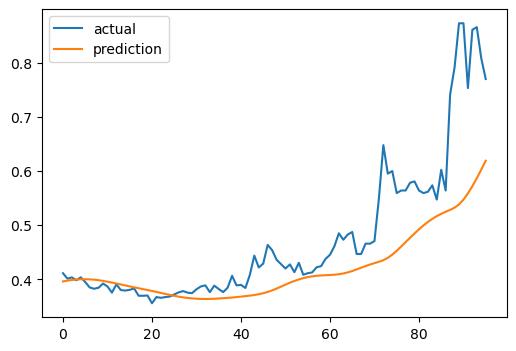

In [260]:
plt.figure(figsize=(6, 4))
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [94]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.3f}".format(results[1]))

loss value: 0.219
accuracy value: 0.219


In [116]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.3f}".format(results[1]))

loss value: 0.365
accuracy value: 0.365


In [95]:
results

[0.21926520764827728, 0.21926521]